<a href="https://www.cognitiveclass.ai"><img src = "https://cognitiveclass.ai/wp-content/themes/bdu3.0/static/images/cc-logo.png" align = left></a>

<br>
<br>

--------------------
# SETI CNN using TF and Binary DS

In [1]:
import sys
sys.path.insert(0, "/opt/DL/tensorflow/lib/python2.7/site-packages/")
import requests
import json
#import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
import time
#!sudo pip install sklearn
import os
from sklearn.metrics import confusion_matrix
from sklearn import metrics

### Set your team folder

In [2]:
### SET YOUR TEAM NAME HERE! Use this folder to save intermediate results
team_name = 'p9_launch'
mydatafolder = os.path.join( os.environ['PWD'], team_name )  #Change my_data_folder to your team name
if os.path.exists(mydatafolder) is False:
    os.makedirs(mydatafolder)
print mydatafolder

/home/fbarilla/SETI/ML4SETI/tutorials/p9_launch


### Import dataset reader
The following cell will load a python code to read the SETI dataset.

In [3]:
!wget --output-document SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

--2017-10-05 19:27:02--  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
Resolving ibm.box.com (ibm.box.com)... 107.152.27.197, 107.152.26.197
Connecting to ibm.box.com (ibm.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip [following]
--2017-10-05 19:27:02--  https://ibm.ent.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.26.211, 107.152.27.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.26.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/Fu66q5e_e4cdTger9_b9x9KN4RvQ0SUqYC4Wc8tjp8kjcWxOquA49BdhHvYI3ixY-Dw9pwEIF2ENeSMu600Ahwt2hztOwpbk0g5wuJroMrZWDyCvk4uSgLUsS-kJuHxqFj6V-JaboUvoAz_V0NO_WtwUZPEQ7RBgPKhY3dKrk8XrJwezeqR3G_9Z0nxL3ETHBeKPs2KROl_xDORTxoDFJXQ9yGh8jlHbQ1arIbWdEazYHMcgn15h7gfsJ

/root/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:127: RuntimeWarning: overflow encountered in add
  a = a + a
/root/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:129: RuntimeWarning: invalid value encountered in subtract
  temp1 = temp - a
/root/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:138: RuntimeWarning: invalid value encountered in subtract
  itemp = int_conv(temp-a)
/root/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:162: RuntimeWarning: overflow encountered in add
  a = a + a
/root/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:164: RuntimeWarning: invalid value encountered in subtract
  temp1 = temp - a
/root/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:171: RuntimeWarning: invalid value encountered in subtract
  if any(temp-a != zero):


### Download data

In [4]:
# ds_directory = mydatafolder + '/SETI/SETI_ds_64x128/'
ds_directory = '/tmp/SETI1_data/SETI_ds_64x128'


In [5]:
print os.popen("ls -lrt "+ ds_directory).read() # to verify

total 2384
-rw-r----- 1 501 root     306 May 23 02:11 train-labels-idx1-ubyte.gz
-rw-r----- 1 501 root 1665328 May 23 02:11 train-images-idx3-ubyte.gz
-rw-r----- 1 501 root     172 May 23 02:11 test-labels-idx1-ubyte.gz
-rw-r----- 1 501 root  765379 May 23 02:11 test-images-idx3-ubyte.gz



### Load data SETI

In [6]:
dataset = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
dataset.train.images.shape

Extracting /tmp/SETI1_data/SETI_ds_64x128/train-images-idx3-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/train-labels-idx1-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/test-images-idx3-ubyte.gz
Extracting /tmp/SETI1_data/SETI_ds_64x128/test-labels-idx1-ubyte.gz


(694, 8192)

## Network Parameters

In [7]:
# Parameters
decay_rate=0.96
decay_steps=1000
learning_rate = 0.005
training_epochs = 200
batch_size = 50
display_step = 100

#check point directory
chk_directory = mydatafolder+'/save/'
checkpoint_path = chk_directory+'model.ckpt'


n_classes = 4 # number of possible classifications for the problem
dropout = 0.50 # Dropout, probability to keep units

height = 64 # height of the image in pixels 
width = 128 # width of the image in pixels 
n_input = width * height # number of pixels in one image 


### Inputs

In [8]:
x  = tf.placeholder(tf.float32, shape=[None, n_input])
y_ = tf.placeholder(tf.float32, shape=[None, n_classes])

In [9]:
x_image = tf.reshape(x, [-1,height,width,1]) 
x_image

<tf.Tensor 'Reshape:0' shape=(?, 64, 128, 1) dtype=float32>

#### Convolutional Layer 1

In [10]:
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs
convolve1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
h_conv1 = tf.nn.relu(convolve1)
conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
conv1

<tf.Tensor 'MaxPool:0' shape=(?, 32, 64, 32) dtype=float32>

#### Convolutional Layer 2

In [11]:
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs
convolve2= tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')+ b_conv2
h_conv2 = tf.nn.relu(convolve2)
conv2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 4, 4, 1], padding='SAME') #max_pool_2x2
conv2

<tf.Tensor 'MaxPool_1:0' shape=(?, 8, 16, 64) dtype=float32>

#### Fully Connected Layer 1

In [12]:
input_layer = conv2
dim = input_layer.get_shape().as_list()
dim

[None, 8, 16, 64]

In [13]:
dims= dim[1]*dim[2]*dim[3]
nodes1 = 1024
prv_layer_matrix = tf.reshape(input_layer, [-1, dims])
W_fc1 = tf.Variable(tf.truncated_normal([dims, nodes1], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[nodes1])) # need 1024 biases for 1024 outputs
h_fcl1  = tf.matmul(prv_layer_matrix, W_fc1) + b_fc1
fc_layer1 = tf.nn.relu(h_fcl1) # ???
fc_layer1


<tf.Tensor 'Relu_2:0' shape=(?, 1024) dtype=float32>

#### Droupout 1

In [14]:
keep_prob = tf.placeholder(tf.float32)
layer_drop1 = tf.nn.dropout(fc_layer1, keep_prob)

#### Readout Layer

In [15]:
W_fc = tf.Variable(tf.truncated_normal([nodes1, n_classes], stddev=0.1)) #1024 neurons
b_fc = tf.Variable(tf.constant(0.1, shape=[n_classes])) # 10 possibilities for classes [0,1,2,3]
fc = tf.matmul(layer_drop1, W_fc) + b_fc
y_CNN= tf.nn.softmax(fc)

#### Loss function

In [16]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_CNN, labels=y_))

#### Training


In [17]:
# Create a variable to track the global step.
global_step = tf.Variable(0, trainable=False)

# create learning_decay
lr = tf.train.exponential_decay( learning_rate,
                                 global_step,
                                 decay_steps,
                                 decay_rate, staircase=True )

In [18]:
# Use the optimizer to apply the gradients that minimize the loss
# (and also increment the global step counter) as a single training step.
optimizer = tf.train.GradientDescentOptimizer(lr)

train_op = optimizer.minimize(cross_entropy, global_step=global_step)
#train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

#### Evaluation

In [19]:
correct_prediction = tf.equal(tf.argmax(y_CNN,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Create checkpoint directory

In [20]:
directory = os.path.dirname(chk_directory)
try:
    os.stat(directory)
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    print ckpt
except:
    os.mkdir(directory) 

model_checkpoint_path: "/home/fbarilla/SETI/ML4SETI/tutorials/p9_launch/save/model.ckpt-11000"
all_model_checkpoint_paths: "/home/fbarilla/SETI/ML4SETI/tutorials/p9_launch/save/model.ckpt-11000"



## Training

In [21]:
# Initializing the variables
init = tf.global_variables_initializer()

In [22]:
loss_values = []
with tf.Session() as sess:

    
    X_test = dataset.test.images
    y_test = dataset.test.labels
    sess.run(init)
    saver = tf.train.Saver(tf.global_variables())
    
    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    if ckpt:
        print "loading model: ",ckpt.model_checkpoint_path
        #saver.restore(sess, ckpt.model_checkpoint_path)
    
    
    #step = 0
    num_examples = dataset.train.num_examples
    # Training cycle
    for epoch in range(training_epochs):
        avg_loss = 0.
        avg_accuracy = 0.
        #dataset.shuffle_data()
        total_batch = int(num_examples / batch_size)

        # Loop over all batches
        start = time.time()
        for step in range(total_batch):
            x_batch, y_batch = dataset.train.next_batch(batch_size,shuffle=True)
            train_op.run(feed_dict={x: x_batch, y_: y_batch, keep_prob: dropout})
            loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
            
            avg_loss += loss / total_batch
            avg_accuracy += acc / total_batch
            if step % display_step == 1000:

                
                # Calculate batch loss and accuracy
                loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
                #train_accuracy = accuracy.eval(feed_dict={x:x_batch, y_: y_batch,  keep_prob: 0.5})

                test_accuracy = sess.run(accuracy, feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})

                print("Iter " + str(step) + \
                    ", Minibatch Loss= " +  "{:.6f}".format(loss) +  \
                    ", Training Accuracy= " + "{:.5f}".format(acc)  + \
                    ", Test Accuracy= " + "{:.5f}".format(test_accuracy) )
        
        # save model every 1 epochs
        if epoch >= 0 and epoch % 1 == 0:
            # Save model
            #print ("model saved to {}".format(checkpoint_path))
            #saver.save(sess, checkpoint_path, global_step = epoch)
            end = time.time()
            plr = sess.run(lr)
            loss_values.append(avg_loss)
            #print(sess.run(tf.train.global_step()))
            print "Epoch:", '%04d' % (epoch+1) , ", Epoch time=" , "{:.5f}".format(end - start) , ", lr=", "{:.9f}".format(plr), ", cost=", "{:.9f}".format(avg_loss) ,", Acc=", "{:.9f}".format(avg_accuracy)

    print("Optimization Finished!")
    print ("model saved to {}".format(checkpoint_path))
    saver.save(sess, checkpoint_path, global_step = (epoch+1)*step)

    
    
    # Calculate accuracy for test images
    #print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: X_test[0:30], y_: y_test[0:30], keep_prob: 1.}))
        
    # Find the labels of test set
    y_pred_lb = sess.run(tf.argmax(y_CNN,1), feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})
    y_pred = sess.run(y_CNN, feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})
    
    # lets save kernels
    kernels_l1 = sess.run(tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0, 1]),[32,-1]))
    kernels_l2 = sess.run(tf.reshape(tf.transpose(W_conv2, perm=[2, 3, 0, 1]),[32*64,-1]))

loading model:  /home/fbarilla/SETI/ML4SETI/tutorials/p9_launch/save/model.ckpt-11000
Epoch: 0001 , Epoch time= 1.68460 , lr= 0.005000000 , cost= 1.467379653 , Acc= 0.264615378
Epoch: 0002 , Epoch time= 0.72467 , lr= 0.005000000 , cost= 1.424265403 , Acc= 0.269230761
Epoch: 0003 , Epoch time= 0.71568 , lr= 0.005000000 , cost= 1.413489736 , Acc= 0.267692294
Epoch: 0004 , Epoch time= 0.70238 , lr= 0.005000000 , cost= 1.358109373 , Acc= 0.356923065
Epoch: 0005 , Epoch time= 0.70192 , lr= 0.005000000 , cost= 1.281199419 , Acc= 0.475384600
Epoch: 0006 , Epoch time= 0.70346 , lr= 0.005000000 , cost= 1.302371603 , Acc= 0.418461529
Epoch: 0007 , Epoch time= 0.70398 , lr= 0.005000000 , cost= 1.276326455 , Acc= 0.489230754
Epoch: 0008 , Epoch time= 0.70050 , lr= 0.005000000 , cost= 1.263157294 , Acc= 0.464615375
Epoch: 0009 , Epoch time= 0.70255 , lr= 0.005000000 , cost= 1.251506310 , Acc= 0.486153830
Epoch: 0010 , Epoch time= 0.70113 , lr= 0.005000000 , cost= 1.237061024 , Acc= 0.495384601
Epoc

Epoch: 0091 , Epoch time= 0.70441 , lr= 0.004800000 , cost= 1.176467400 , Acc= 0.530769211
Epoch: 0092 , Epoch time= 0.70280 , lr= 0.004800000 , cost= 1.162774755 , Acc= 0.530769215
Epoch: 0093 , Epoch time= 0.70400 , lr= 0.004800000 , cost= 1.167756557 , Acc= 0.541538438
Epoch: 0094 , Epoch time= 0.70725 , lr= 0.004800000 , cost= 1.164410032 , Acc= 0.550769210
Epoch: 0095 , Epoch time= 0.70527 , lr= 0.004800000 , cost= 1.166129938 , Acc= 0.552307679
Epoch: 0096 , Epoch time= 0.70631 , lr= 0.004800000 , cost= 1.164292216 , Acc= 0.550769217
Epoch: 0097 , Epoch time= 0.70744 , lr= 0.004800000 , cost= 1.165423155 , Acc= 0.556923064
Epoch: 0098 , Epoch time= 0.70351 , lr= 0.004800000 , cost= 1.173448058 , Acc= 0.549230752
Epoch: 0099 , Epoch time= 0.70327 , lr= 0.004800000 , cost= 1.170537123 , Acc= 0.523076896
Epoch: 0100 , Epoch time= 0.70621 , lr= 0.004800000 , cost= 1.156579880 , Acc= 0.567692287
Epoch: 0101 , Epoch time= 0.70707 , lr= 0.004800000 , cost= 1.177537579 , Acc= 0.536923053

Epoch: 0182 , Epoch time= 0.70695 , lr= 0.004608000 , cost= 1.161272003 , Acc= 0.532307671
Epoch: 0183 , Epoch time= 0.70570 , lr= 0.004608000 , cost= 1.161950469 , Acc= 0.546153830
Epoch: 0184 , Epoch time= 0.70830 , lr= 0.004608000 , cost= 1.153970792 , Acc= 0.553846128
Epoch: 0185 , Epoch time= 0.70679 , lr= 0.004608000 , cost= 1.162071641 , Acc= 0.544615365
Epoch: 0186 , Epoch time= 0.70827 , lr= 0.004608000 , cost= 1.161281366 , Acc= 0.553846130
Epoch: 0187 , Epoch time= 0.70949 , lr= 0.004608000 , cost= 1.162436164 , Acc= 0.550769217
Epoch: 0188 , Epoch time= 0.70691 , lr= 0.004608000 , cost= 1.157337785 , Acc= 0.567692296
Epoch: 0189 , Epoch time= 0.70418 , lr= 0.004608000 , cost= 1.162427673 , Acc= 0.552307670
Epoch: 0190 , Epoch time= 0.70687 , lr= 0.004608000 , cost= 1.165192925 , Acc= 0.530769211
Epoch: 0191 , Epoch time= 0.70974 , lr= 0.004608000 , cost= 1.159025009 , Acc= 0.556923064
Epoch: 0192 , Epoch time= 0.70604 , lr= 0.004608000 , cost= 1.162760964 , Acc= 0.546153830

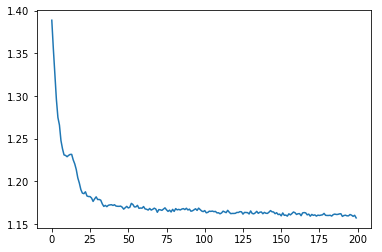

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(loss_values[i:i+5]) for i in range(len(loss_values))])
plt.show()


## Evaluation

Accuracy is depend on the number of epoch that you set in partametrs part.

In [24]:
y_ = np.argmax(y_test[0:100],1) # ground truth
print metrics.classification_report(y_true= y_, y_pred= y_pred_lb)
print metrics.confusion_matrix(y_true= y_, y_pred= y_pred_lb)
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true= y_, y_pred= y_pred_lb) )
print("Log Loss: %0.6f" % metrics.log_loss(y_true= y_, y_pred= y_pred, labels=range(4)) )

             precision    recall  f1-score   support

          0       0.45      0.56      0.50        25
          1       0.00      0.00      0.00        28
          2       0.24      0.48      0.32        23
          3       1.00      1.00      1.00        24

avg / total       0.41      0.49      0.44       100

[[14  0 11  0]
 [ 5  0 23  0]
 [12  0 11  0]
 [ 0  0  0 24]]
Classification accuracy: 0.490000
Log Loss: 0.900428


/root/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Viz

In [25]:
!wget --output-document utils1.py http://deeplearning.net/tutorial/code/utils.py
import utils1
from utils1 import tile_raster_images

--2017-10-05 19:33:28--  http://deeplearning.net/tutorial/code/utils.py
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/plain]
Saving to: ‘utils1.py’

utils1.py           100%[===================>]   4.98K  --.-KB/s    in 0s      

2017-10-05 19:33:28 (512 MB/s) - ‘utils1.py’ saved [5097/5097]



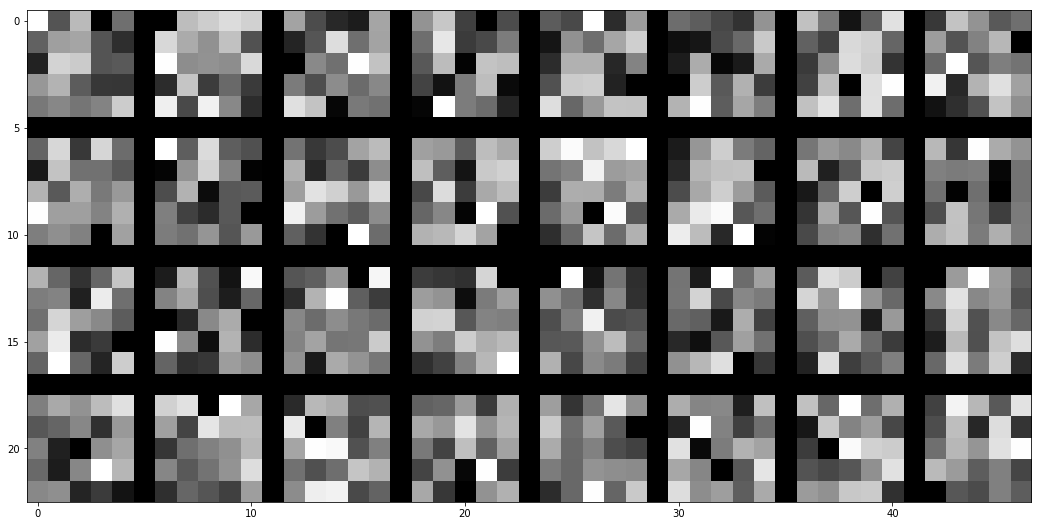

In [26]:
#from utils import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels_l1, img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

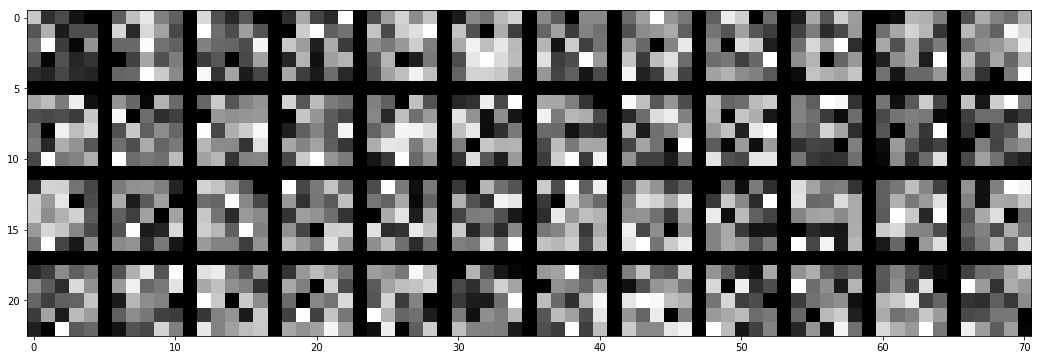

In [27]:
image = Image.fromarray(tile_raster_images(kernels_l2, img_shape=(5, 5) ,tile_shape=(4, 12), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

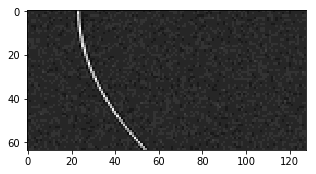

In [28]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage1 = X_test[3]
plt.imshow(np.reshape(sampleimage1,[64,128]), cmap="gray")

Instructions for updating:
Please use tf.global_variables instead.
loading model:  /home/fbarilla/SETI/ML4SETI/tutorials/p9_launch/save/model.ckpt-2400
INFO:tensorflow:Restoring parameters from /home/fbarilla/SETI/ML4SETI/tutorials/p9_launch/save/model.ckpt-2400


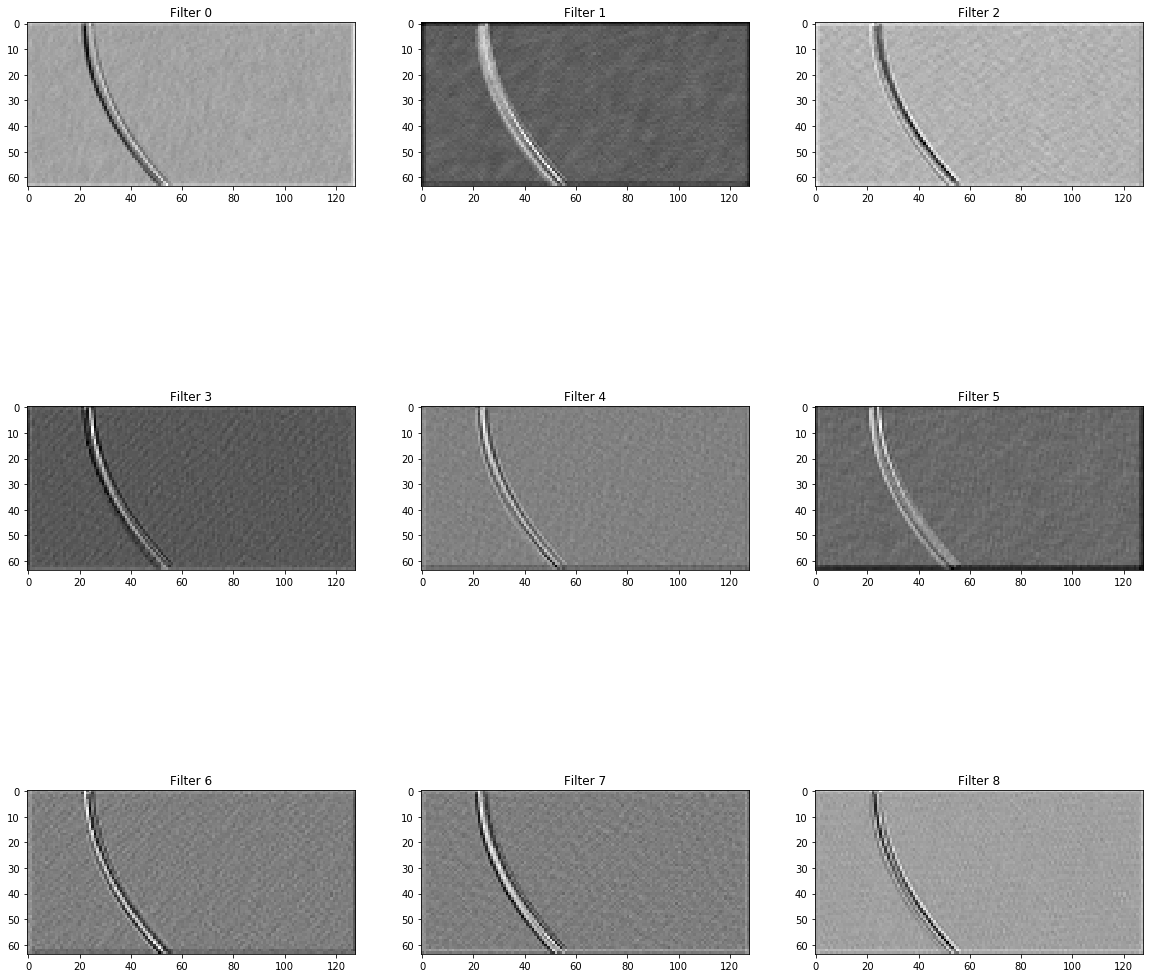

In [29]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver(tf.all_variables())
    
    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    if ckpt:
        print "loading model: ",ckpt.model_checkpoint_path
        saver.restore(sess, ckpt.model_checkpoint_path)
    ActivatedUnits1 = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage1,[1,64*128],order='F'),keep_prob:1.0})
    plt.figure(1, figsize=(20,20))
    n_columns = 3
    n_rows = 3
    for i in range(9):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(ActivatedUnits1[0,:,:,i], interpolation="nearest", cmap="gray")